## 0. Libarary 불러오기 및 경로설정

In [53]:
import os
import shutil
import sys
from glob import glob

import pandas as pd
import numpy as np
import random


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from albumentations import *

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [54]:
# 트레인 데이터셋 폴더 경로
test_dir = '/opt/ml/input/data/train'

# EDA

In [55]:
# EDA 데이터 개략
train_ds = pd.read_csv(test_dir+'/train.csv',  index_col='id')
train_ds.head()

gender   race  age                    path
id                                                
000001  female  Asian   45  000001_female_Asian_45
000002  female  Asian   52  000002_female_Asian_52
000004    male  Asian   54    000004_male_Asian_54
000005  female  Asian   58  000005_female_Asian_58
000006  female  Asian   59  000006_female_Asian_59

In [56]:
len(train_ds)

2700

In [57]:
train_ds.groupby('gender').count()['race']

gender
female    1658
male      1042
Name: race, dtype: int64

In [58]:
bins = [0, 29, 59, 120]
train_ds['age'].value_counts(bins=bins, sort=False) 

(-0.001, 29.0]    1281
(29.0, 59.0]      1227
(59.0, 120.0]      192
Name: age, dtype: int64

# Classify Data by Class 

In [59]:
# make dir for trainset
# 3class
for path in ['/opt/ml/input/data/train_3class']:
    os.makedirs(os.path.dirname(f'{path}/age/30to60/'), exist_ok=True)
    os.makedirs(os.path.dirname(f'{path}/age/from60/'), exist_ok=True)
    os.makedirs(os.path.dirname(f'{path}/age/under30/'), exist_ok=True)
    os.makedirs(os.path.dirname(f'{path}/gender/female/'), exist_ok=True)
    os.makedirs(os.path.dirname(f'{path}/gender/male/'), exist_ok=True)
    os.makedirs(os.path.dirname(f'{path}/mask/correct/'), exist_ok=True)
    os.makedirs(os.path.dirname(f'{path}/mask/incorrect/'), exist_ok=True)
    os.makedirs(os.path.dirname(f'{path}/mask/no/'), exist_ok=True)
# 18class
for path in ['/opt/ml/input/data/val_18class', '/opt/ml/input/data/train_18class']:
    for i in range(18):
        os.makedirs(os.path.dirname(f'{path}/{i}/'), exist_ok=True)

In [60]:
# labeling by 3 class
# by mask class
for person in train_ds['path']:
    os.chdir('/opt/ml/input/data')
    img_lst = os.listdir(f'train/images/{person}')
    person_id = person.split('_')[0]
    for photo_n in img_lst:
        fl = photo_n[0]
        if fl == 'm':
            shutil.copy(f'train/images/{person}/{photo_n}', f'train_3class/mask/correct/{person}_{photo_n}')
        elif fl == 'i':
            shutil.copy(f'train/images/{person}/{photo_n}', f'train_3class/mask/incorrect/{person}_{photo_n}')
        elif fl == 'n':
            shutil.copy(f'train/images/{person}/{photo_n}', f'train_3class/mask/no/{person}_{photo_n}')
            
# by gender class
for person in train_ds['path']:
    os.chdir('/opt/ml/input/data')
    img_lst = os.listdir(f'train/images/{person}')
    gender= person.split('_')[1]
    person_id = person.split('_')[0]
    for photo_n in img_lst:
        fl = photo_n[0]
        if fl != '.':
            if gender == 'female':
                shutil.copy(f'train/images/{person}/{photo_n}', f'train_3class/gender/female/{person}_{photo_n}')
            else:
                shutil.copy(f'train/images/{person}/{photo_n}', f'train_3class/gender/male/{person}_{photo_n}')
                
# by age class
for person in train_ds['path']:
    os.chdir('/opt/ml/input/data')
    img_lst = os.listdir(f'train/images/{person}')
    age = int(person.split('_')[3])
    person_id = person.split('_')[0]
    for photo_n in img_lst:
        fl = photo_n[0]
        if fl != '.':
            if age < 30:
                shutil.copy(f'train/images/{person}/{photo_n}', f'train_3class/age/under30/{person}_{photo_n}')
            elif age < 60:
                shutil.copy(f'train/images/{person}/{photo_n}', f'train_3class/age/30to60/{person}_{photo_n}')
            else:
                shutil.copy(f'train/images/{person}/{photo_n}', f'train_3class/age/from60/{person}_{photo_n}')

In [61]:
# labeling by 18 class
for person in train_ds['path']:
    os.chdir('/opt/ml/input/data')
    img_lst = os.listdir(f'train/images/{person}')
    gender= person.split('_')[1]
    age = int(person.split('_')[3])
    for photo_n in img_lst:
        fl = photo_n[0]
        if fl == 'm':
            if gender != 'female':
                if age < 30:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/0/{person}_{photo_n}')
                elif age < 60:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/1/{person}_{photo_n}')
                else:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/2/{person}_{photo_n}')
            else:
                if age < 30:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/3/{person}_{photo_n}')
                elif age < 60:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/4/{person}_{photo_n}')
                else:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/5/{person}_{photo_n}')
        elif fl == 'i':
            if gender != 'female':
                if age < 30:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/6/{person}_{photo_n}')
                elif age < 60:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/7/{person}_{photo_n}')
                else:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/8/{person}_{photo_n}')
            else:
                if age < 30:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/9/{person}_{photo_n}')
                elif age < 60:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/10/{person}_{photo_n}')
                else:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/11/{person}_{photo_n}')
        elif fl == 'n':
            if gender != 'female':
                if age < 30:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/12/{person}_{photo_n}')
                elif age < 60:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/13/{person}_{photo_n}')
                else:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/14/{person}_{photo_n}')
            else:
                if age < 30:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/15/{person}_{photo_n}')
                elif age < 60:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/16/{person}_{photo_n}')
                else:
                    shutil.copy(f'train/images/{person}/{photo_n}', f'train_18class/17/{person}_{photo_n}')

# Integrity Check

In [62]:
os.chdir('/opt/ml/input/data')
img_lst = glob(os.path.join(f'/opt/ml/input/data/train_18class', '*/*'))

n_photo = len(img_lst)
n_people = len(train_ds)
print('total number of photos:', n_photo)
print('total number of people:', n_people)

mask_n = 0
for i in range(6):
    mask_n += len(glob(os.path.join(f"/opt/ml/input/data/train_18class", f"{i}/*")))
# check integrity of mask
print(mask_n == n_people*5)

male_n = 0
for i in [0,1,2,6,7,8,12,13,14]:
    male_n += len(glob(os.path.join(f"/opt/ml/input/data/train_18class", f"{i}/*")))
# check integrity of male
print(male_n == train_ds.groupby('gender').count()['race']['male']*7)

age_n = 0
for i in [0,3,6,9,12,15]:
    age_n += len(glob(os.path.join(f"/opt/ml/input/data/train_18class", f"{i}/*")))
# check integrity of age
print(age_n == train_ds['age'].value_counts(bins=bins, sort=False)[0]*7)

total number of photos: 18900
total number of people: 2700
True
True
True


In [63]:
os.chdir('/opt/ml/input/data')
img_lst = glob(os.path.join(f'/opt/ml/input/data/train_3class', '*/*/*'))

n_photo = len(img_lst)
n_people = len(train_ds)
print('total number of photos:', n_photo)
print('total number of people:', n_people)
# photo number integrity check
print(n_photo == n_people*7*3)

# age integrity
print(len(glob(os.path.join(f'/opt/ml/input/data/train_3class/age', '30to60/*'))) == 1227*7)
# gender integrity
print(len(glob(os.path.join(f'/opt/ml/input/data/train_3class/gender', 'female/*')))==train_ds.groupby('gender').count()['race']['female']*7)

total number of photos: 56700
total number of people: 2700
True
True
True


# Modify Wrongly Labelled data

In [64]:
check1 = 42
check2 = 14
check3 = 6

for i in range(0,18):
    img_lst = glob(os.path.join(f'/opt/ml/input/data/train_18class', f'{i}/*'))
    for img_name in img_lst:
        idn = img_name.split('_')[1].split('/')[-1]
        if idn in ['006359', '006360', '006361', '006362', '006363', '006364']:
            #print(img_name)
            #print(f'/opt/ml/input/data/train_18class/{i-3}/r{img_name.split("/")[-1][1:]}')
            shutil.move(img_name, f'/opt/ml/input/data/train_18class/{i-3}/r{img_name.split("/")[-1][1:]}')
            check1 -= 1
        elif idn in ['001498-1', '004432']:
            #print(img_name)
            #print(f'/opt/ml/input/data/train_18class/{i+3}/{img_name.split("/")[-1]}')
            shutil.move(img_name, f'/opt/ml/input/data/train_18class/{i+3}/r{img_name.split("/")[-1][1:]}')
            check2 -= 1
        elif idn in ['000020', '004418', '005227']:
            if 'incorrect' in img_name:
                #print(img_name)
                #print(f'/opt/ml/input/data/train_18class/{i+6}/{img_name.split("/")[-1]}')
                shutil.move(img_name, f'/opt/ml/input/data/train_18class/{i+6}/r{img_name.split("/")[-1][1:]}')
                check3 -=1
            elif 'normal' in img_name:
                #print(img_name)
                #print(f'/opt/ml/input/data/train_18class/{i-6}/{img_name.split("/")[-1]}')
                shutil.move(img_name, f'/opt/ml/input/data/train_18class/{i-6}/r{img_name.split("/")[-1][1:]}')
                check3 -= 1
    
if check1 ==0 and check2 ==0 and check3 ==0:
    print(True)
else:
    print(False)

True


# Split Stratified Validation Dataset

In [65]:
import random

for i in range(0,6):
    img_lst = glob(os.path.join(f'/opt/ml/input/data/train_18class', f'{i}/*'))
    id_lst = []
    for img_name in img_lst:
        id_lst.append(img_name.split('_')[1].split('/')[-1])
    id_lst = list(set(id_lst))
    random.shuffle(id_lst)
    id_lst = id_lst[:int(len(id_lst)*0.2)]
    
    for j in [0,6,12]:
        new_img_lst = glob(os.path.join(f'/opt/ml/input/data/train_18class', f'{i+j}/*'))
        for ide in id_lst:
            for new_img_name in new_img_lst:
                if new_img_name.split('_')[1].split('/')[-1] == ide:
                    name = new_img_name.split('/')[-1]
                    shutil.move(new_img_name, f'val_18class/{i+j}/{name}')

# Split Integrity Check

In [66]:
# check if any same person in both train and validation
for i in range(0,18):
    img_lst = glob(os.path.join(f'/opt/ml/input/data/val_18class', f'{i}/*'))
    v_id_lst = []
    for img_name in img_lst:
        v_id_lst.append(img_name.split('_')[1].split('/')[-1])

    img_lst = glob(os.path.join(f'/opt/ml/input/data/train_18class', f'{i}/*'))
    t_id_lst = []
    for img_name in img_lst:
        t_id_lst.append(img_name.split('_')[1].split('/')[-1])

    if set(v_id_lst) & set(t_id_lst):
        print(False)
    else:
        print(True)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [67]:
# check if 2:8 split is done
for i in range(0,18):
    v_img_lst = glob(os.path.join(f'/opt/ml/input/data/val_18class', f'{i}/*'))
    t_img_lst = glob(os.path.join(f'/opt/ml/input/data/train_18class', f'{i}/*'))
    v = len(v_img_lst)/(len(t_img_lst)+len(v_img_lst))
    print(0.19<v<0.2)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Augumentation

In [ ]:
data_dir = '/opt/ml/input/data/train_3class/gender'

img_paths = glob(os.path.join(f'{data_dir}/', 'female/*'))

In [ ]:
len(img_paths)

7448

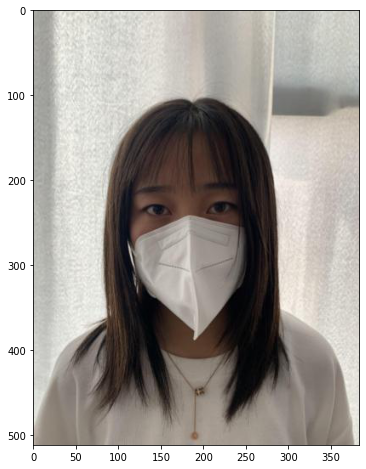

In [ ]:
random.shuffle(img_paths)
img = np.array(Image.open(img_paths[0]))

plt.figure(figsize=(16,8))
plt.imshow(img)

In [ ]:
img.shape

(512, 384, 3)

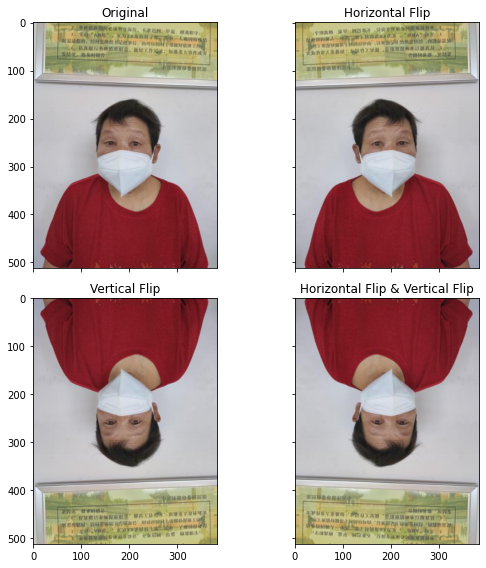

In [ ]:
n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

axes[0][0].imshow(img)
axes[0][0].set_title(f'Original')

trfm = Compose([
            HorizontalFlip(p=1.0),
        ], p=1.0)
axes[0][1].imshow(trfm(image=img)['image'])
axes[0][1].set_title(f'Horizontal Flip')

trfm = Compose([
            VerticalFlip(p=1.0),
        ], p=1.0)
axes[1][0].imshow(trfm(image=img)['image'])
axes[1][0].set_title(f'Vertical Flip')

trfm = Compose([
            HorizontalFlip(p=1.0),
            VerticalFlip(p=1.0),
        ], p=1.0)
axes[1][1].imshow(trfm(image=img)['image'])
axes[1][1].set_title(f'Horizontal Flip & Vertical Flip')

plt.tight_layout()

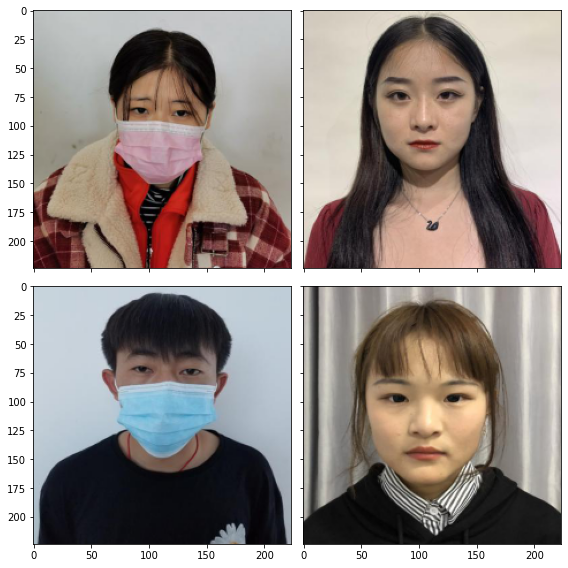

In [ ]:
random.shuffle(img_paths)

n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

trfm = Compose([
            CenterCrop(height=400, width=384, p=1.0),
            Resize(224,224),
        ], p=1.0)

for i in range(2):
    for j in range(2):
        img = np.array(Image.open(img_paths[i*2+j]))
        axes[i][j].imshow(trfm(image=img)['image'])

plt.tight_layout()

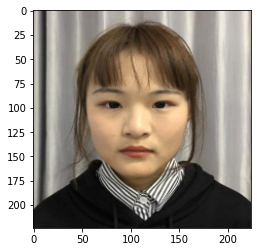

In [ ]:
plt.plot()
trfm = Compose([
            CenterCrop(height=400, width=384, p=1.0),
            Resize(224,224),
        ], p=1.0)
        
plt.imshow((trfm(image=img))['image'])

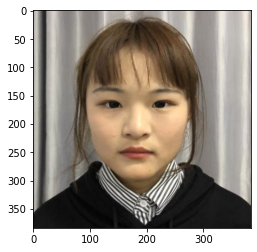

In [ ]:
plt.plot()
trfm = Compose([
            CenterCrop(height=384, width=384, p=1.0),
        ], p=1.0)
        
plt.imshow((trfm(image=img))['image'])

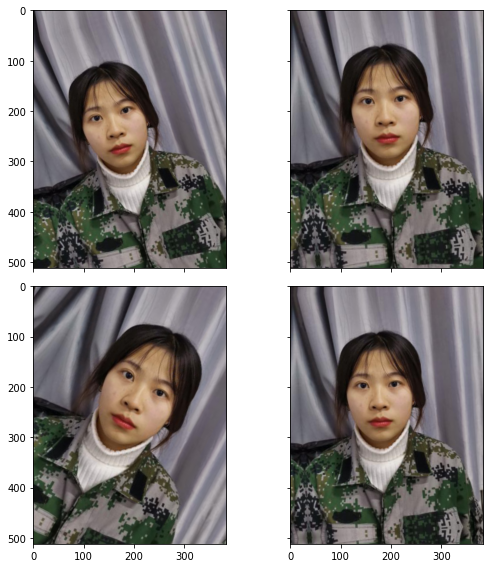

In [ ]:
n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

trfm = Compose([
            ShiftScaleRotate(p=1.0),
        ], p=1.0)
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//n_cols].imshow(trfm(image=img)['image'])

plt.tight_layout()

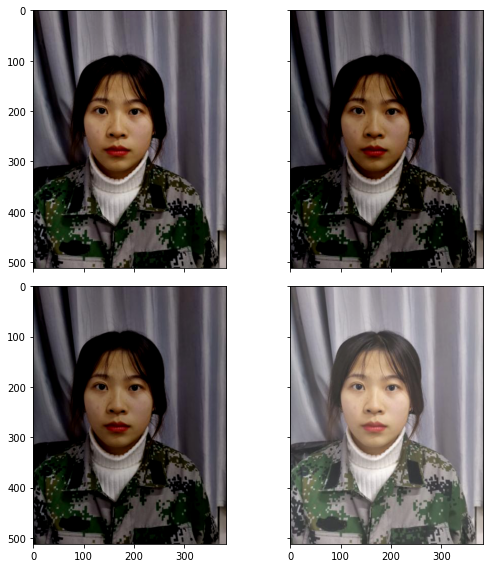

In [ ]:
n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

trfm = Compose([
            RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=1.0),
        ], p=1.0)
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//n_cols].imshow(trfm(image=img)['image'])

plt.tight_layout()

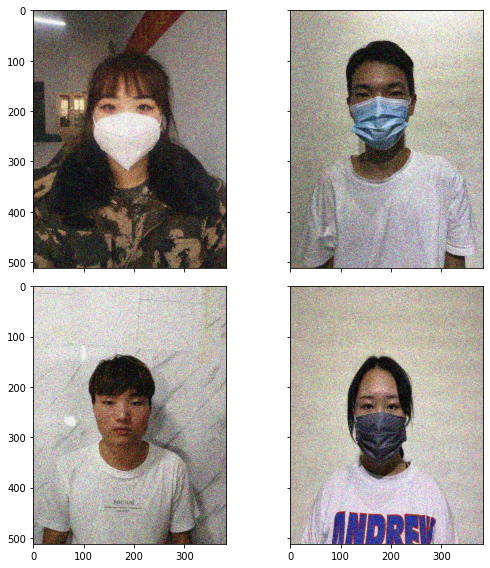

In [ ]:
n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 8))

trfm = Compose([
            GaussNoise(var_limit=(1000, 1600), p=1.0),
        ], p=1.0)
random.shuffle(img_paths)
for i in range(n_rows*n_cols):
    _img = np.array(Image.open(img_paths[i]))
    axes[i%n_rows][i//n_cols].imshow(trfm(image=_img)['image'])

plt.tight_layout()

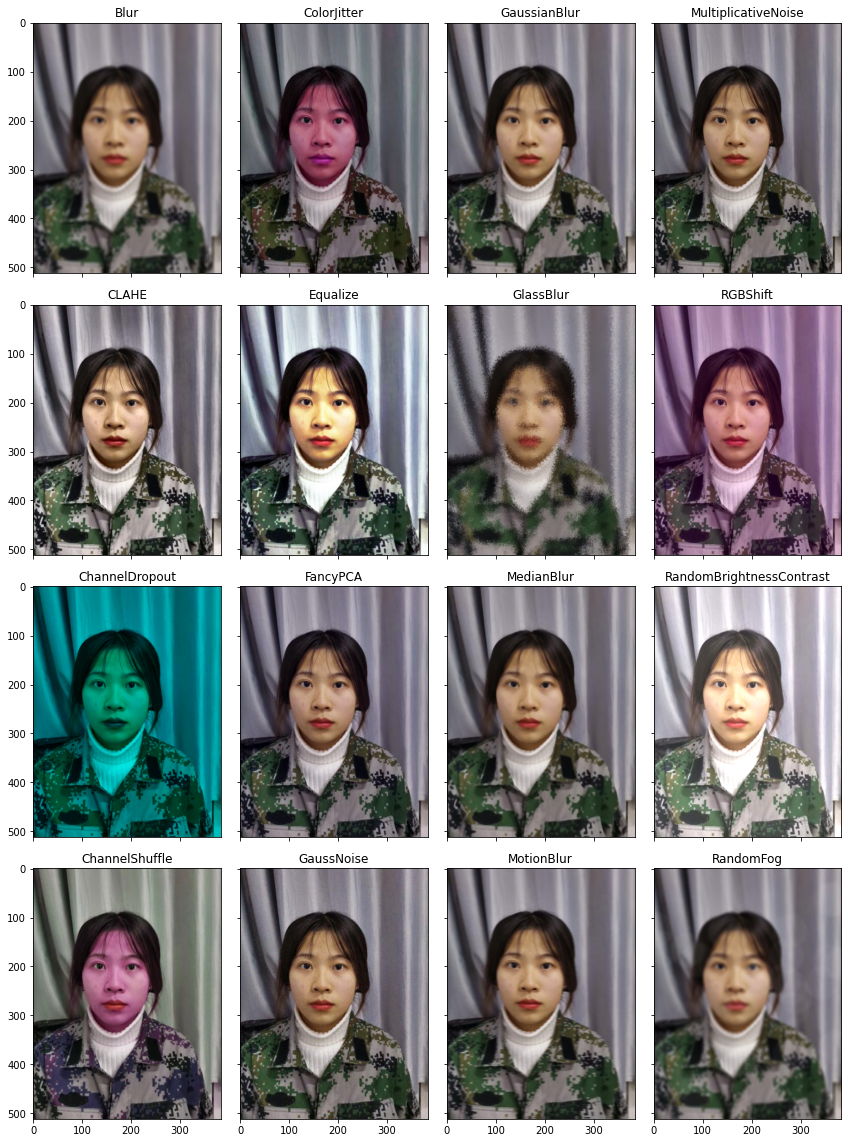

In [ ]:
n_rows, n_cols = 4, 4

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(12, 16))

trfm_ls = [Blur,
           CLAHE,
           ChannelDropout,
           ChannelShuffle,
           ColorJitter,
           Equalize,
           FancyPCA,
           GaussNoise,
           GaussianBlur,
           GlassBlur,
           MedianBlur,
           MotionBlur,
           MultiplicativeNoise,
           RGBShift,
           RandomBrightnessContrast,
           RandomFog,
           Solarize]
for i in range(n_rows*n_cols):
    trfm = Compose([Resize(height=512, width=384, p=1.0), trfm_ls[i](p=1.0)])
    axes[i%n_rows][i//n_cols].imshow(trfm(image=img)['image'])
    axes[i%n_rows][i//n_cols].set_title(f'{trfm_ls[i].__name__}')

plt.tight_layout()

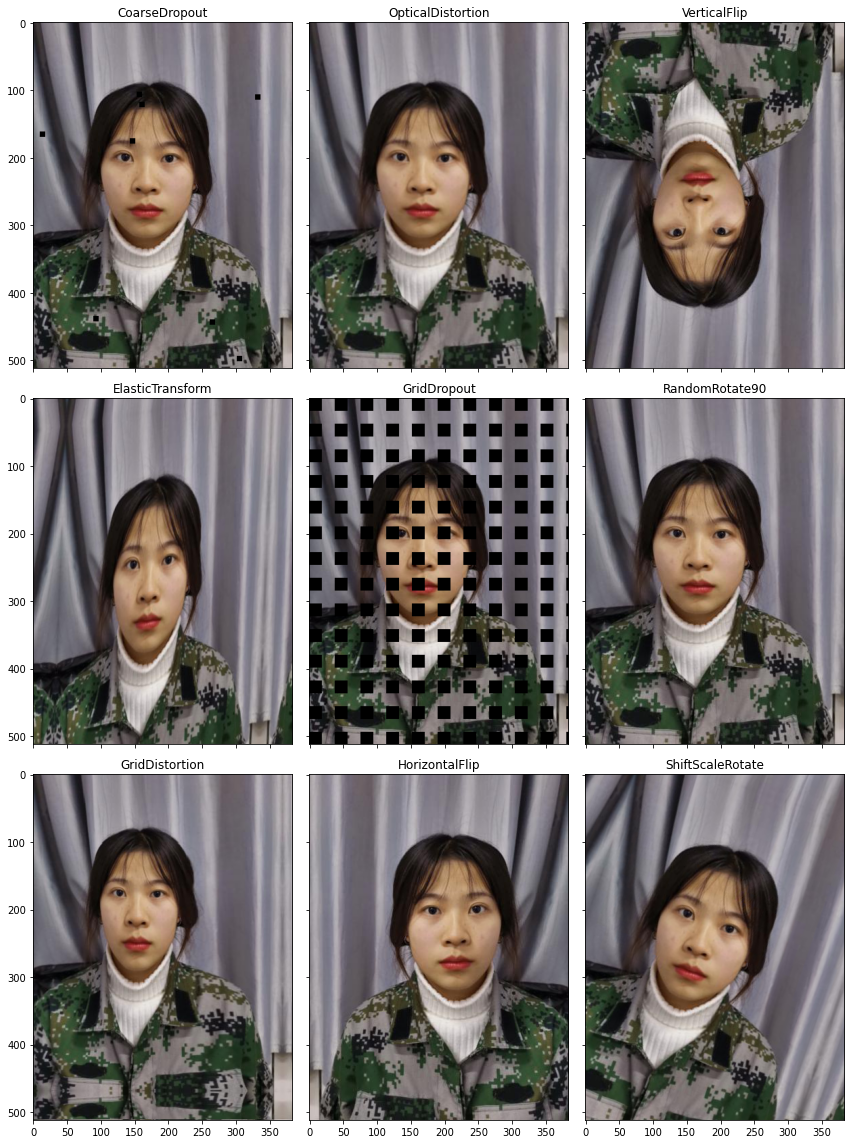

In [ ]:
n_rows, n_cols = 3, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(12, 16))

trfm_ls = [CoarseDropout,
           ElasticTransform,
           GridDistortion,
           OpticalDistortion,
           GridDropout,
           HorizontalFlip,
           VerticalFlip,
           RandomRotate90,
           ShiftScaleRotate]
for i in range(n_rows*n_cols):
    trfm = Compose([Resize(height=512, width=384, p=1.0), trfm_ls[i](p=1.0)])
    axes[i%n_rows][i//n_cols].imshow(trfm(image=img)['image'])
    axes[i%n_rows][i//n_cols].set_title(f'{trfm_ls[i].__name__}')

plt.tight_layout()